In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.utils.data import DataLoader
from dataset.traffic_dataset import TrafficDataset
from utils.Trainer import Trainer
import numpy as np


class MAPELoss(nn.Module):
    """
    안정화를 위해 true 값이 작은 경우 eps로 클램프한 후 계산합니다.
    """
    def __init__(self, eps: float = 1e-3):
        super().__init__()
        self.eps = eps

    def forward(self, pred: torch.Tensor, true: torch.Tensor) -> torch.Tensor:
        # 분모가 너무 작아지는 것을 방지
        denom = torch.clamp(true.abs(), min=self.eps)
        loss = torch.abs((pred - true) / denom)
        return loss.mean()


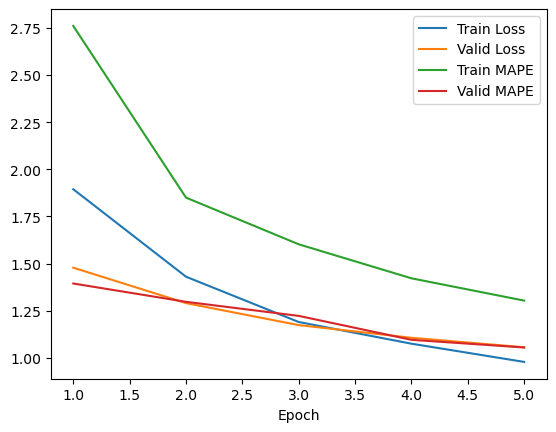

Train 6/30:   0%|          | 0/105 [00:00<?, ?it/s]

KeyboardInterrupt: 

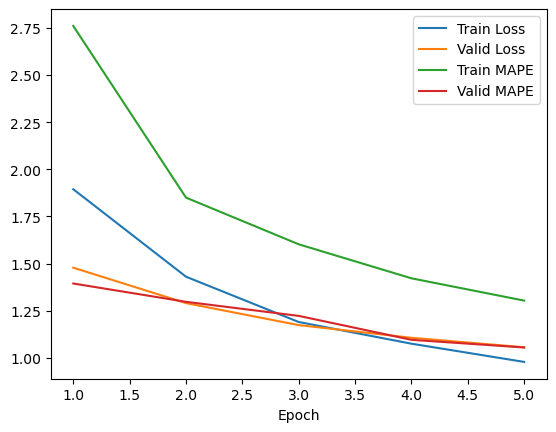

In [6]:
# 1) 하이퍼파라미터
BATCH_SIZE = 32
EPOCHS = 30
LEARNING_RATE = 1e-3
WINDOW = 12                   # 입력 시퀀스 길이
N_PRED = 3                    # 예측 시퀀스 길이
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# 2) 데이터 준비 (NumPy 로드 → Dataset → DataLoader)
data = np.load('dataset/traffic_dataset_13_smoothen.npy')  # (T_total, E, C_all)
# train/valid split (예: 시계열 뒤쪽 20%를 검증으로)


split_idx = int(data.shape[0] * 0.8)
train_data, valid_data = data[:split_idx], data[split_idx:]

def collate_fn(batch):
    xs = torch.stack([item.x for item in batch], dim=0)
    ys = torch.stack([item.y for item in batch], dim=0)
    return xs, ys

train_ds = TrafficDataset(train_data, window=WINDOW, randomize=True)
valid_ds = TrafficDataset(valid_data, window=WINDOW, randomize=False)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

# 3) Baseline 모델 정의
class MLPBaseline(nn.Module):
    def __init__(self, T, E, D_in, n_pred, D_out, hidden_dim=256, dropout=0.1):
        super().__init__()
        self.n_pred, self.E, self.D_out = n_pred, E, D_out
        self.network = nn.Sequential(
            nn.Flatten(),  # B x (T*E*D_in)
            nn.Linear(T * E * D_in, hidden_dim),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2*hidden_dim),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Linear(2*hidden_dim, 2*hidden_dim),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Linear(2*hidden_dim, hidden_dim),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Linear(hidden_dim, n_pred * E * D_out)
        )

    def forward(self, x, edge_index=None, edge_attr=None):
        # x: [B, T, E, D_in]
        B = x.size(0)
        out = self.network(x)
        out = out.view(B, self.n_pred, self.E, self.D_out)
        return out


class ResidualMLPBlock(nn.Module):
    def __init__(self, dim, dropout=0.1):
        super().__init__()
        self.fc1 = nn.Linear(dim, dim)
        self.ln1 = nn.LayerNorm(dim)
        self.fc2 = nn.Linear(dim, dim)
        self.ln2 = nn.LayerNorm(dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # x: [B, *, dim]
        residual = x
        out = self.fc1(x)
        out = self.ln1(out)
        out = F.relu(out)
        out = self.dropout(out)

        out = self.fc2(out)
        out = self.ln2(out)
        out = F.relu(out)
        out = self.dropout(out)

        return out + residual


class ResidualMLPBaseline(nn.Module):
    def __init__(self, T, E, D_in, n_pred, D_out, hidden_dim=256, dropout=0.1):
        super().__init__()
        self.n_pred, self.E, self.D_out = n_pred, E, D_out
        self.input_dim = T * E * D_in
        self.hidden_dim = hidden_dim

        # 입력을 hidden_dim 차원으로 투사
        self.fc_in = nn.Linear(self.input_dim, hidden_dim)
        self.ln_in = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(dropout)

        # Residual 블록 3개
        self.res_blocks = nn.Sequential(
            ResidualMLPBlock(hidden_dim, dropout),
            ResidualMLPBlock(hidden_dim, dropout),
            ResidualMLPBlock(hidden_dim, dropout),
        )

        # 출력층
        self.fc_out = nn.Linear(hidden_dim, n_pred * E * D_out)

    def forward(self, x, edge_index=None, edge_attr=None):
        # x: [B, T, E, D_in]
        B = x.size(0)
        # Flatten 및 프로젝션
        h = x.view(B, -1)            # [B, T*E*D_in]
        h = self.fc_in(h)            # [B, hidden_dim]
        h = self.ln_in(h)
        h = F.relu(h)
        h = self.dropout(h)

        # Residual MLP 블록
        h = self.res_blocks(h)       # [B, hidden_dim]

        # 예측치 생성
        out = self.fc_out(h)         # [B, n_pred*E*D_out]
        out = out.view(B, self.n_pred, self.E, self.D_out)
        return out


# class CNN2DBaseline(nn.Module):
#     def __init__(self, T, E, D_in, n_pred, D_out, hidden_dim=128):
#         super().__init__()
#         self.n_pred, self.E, self.D_out = n_pred, E, D_out
#         self.conv = nn.Sequential(
#             nn.Conv2d(D_in, hidden_dim, kernel_size=(3,3), padding=(1,1)),
#             nn.ReLU(),
#             nn.Conv2d(hidden_dim, hidden_dim, kernel_size=(3,3), padding=(1,1)),
#             nn.ReLU()
#         )
#         self.pool = nn.AdaptiveAvgPool2d((1,1))
#         self.fc = nn.Sequential(
#             nn.Flatten(),
#             nn.Linear(hidden_dim, hidden_dim),
#             nn.ReLU(),
#             nn.Linear(hidden_dim, n_pred * E * D_out)
#         )

#     def forward(self, x, edge_index=None, edge_attr=None):
#         # x: [B, T, E, D_in] -> [B, D_in, T, E]
#         x = x.permute(0, 3, 1, 2)
#         h = self.conv(x)
#         h = self.pool(h)
#         B = x.size(0)
#         out = self.fc(h)
#         out = out.view(B, self.n_pred, self.E, self.D_out)
#         return out

# 4) 손실 함수 & 옵티마이저 설정
# - MSELoss: 평균제곱오차, L1Loss: 평균절대오차 중 선택 가능
criterion = nn.L1Loss()
optimizer_fn = lambda model: AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

# 5) 모델 학습 및 평가
# for ModelClass, name in [(MLPBaseline, "MLP Baseline")]:
for ModelClass, name in [(ResidualMLPBaseline, "Residual MLP Baseline")]:
    print(f"\n=== Training {name} ===")
    # 모델 인스턴스
    sample_batch, _ = next(iter(train_loader))
    _, T, E, D_in = sample_batch.shape
    _, _, _, D_out = sample_batch[..., :3].shape  # y의 채널 수
    model = ModelClass(T, E, D_in, N_PRED, D_out)
    
    # Trainer 초기화
    trainer = Trainer(
        model=model,
        train_loader=train_loader,
        valid_loader=valid_loader,
        optimizer=optimizer_fn(model),
        criterion=criterion,
        epochs=EPOCHS,
        device=DEVICE 
    )
    # 학습 실행
    trainer.fit()
    # 기록 저장 (옵션)
    # history = trainer.get_history()
    # torch.save(model.state_dict(), f"{name.replace(' ', '_').lower()}_best.pt")


C:\Users\gauoo\AppData\Local\Temp\ipykernel_49164\2696080587.py:54: UserWarning: Glyph 52292 (\N{HANGUL SYLLABLE CAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\gauoo\AppData\Local\Temp\ipykernel_49164\2696080587.py:54: UserWarning: Glyph 45328 (\N{HANGUL SYLLABLE NEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\gauoo\miniconda3\envs\d2l\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 52292 (\N{HANGUL SYLLABLE CAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\gauoo\miniconda3\envs\d2l\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 45328 (\N{HANGUL SYLLABLE NEOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


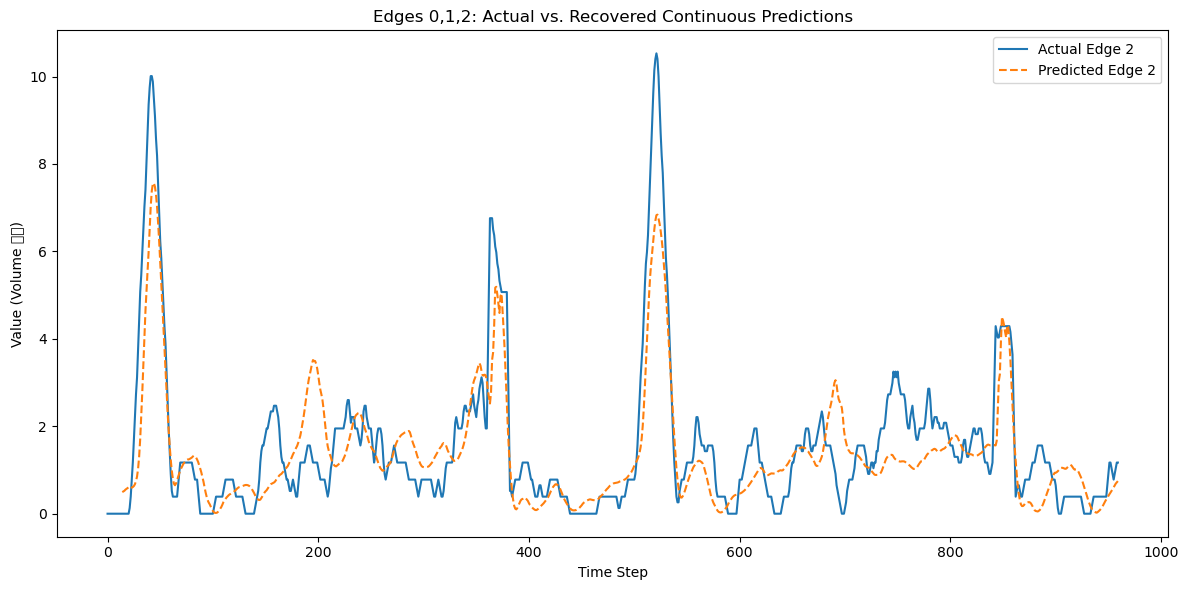

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from collections import defaultdict

# --- 1) 예측 복구용 설정 ---
WINDOW = 12
PRED_OFFSETS = np.array([3, 6, 12])
EDGE_IDS = [2]
T_TOTAL, E, C_ALL = data.shape

# --- 2) 모델을 eval 모드로 전환 ---
model.eval()

# --- 3) 예측값들을 시간별로 저장할 리스트 생성 ---
pred_lists = {edge: defaultdict(list) for edge in EDGE_IDS}

# --- 4) 슬라이딩 윈도우 예측 루프 (0~959까지만) ---
with torch.no_grad():
    for t0 in range(WINDOW - 1, min(960, T_TOTAL - int(PRED_OFFSETS.max()))):
        # (T, E, 3) 채널만 사용
        x_win = data[t0 - WINDOW + 1:t0 + 1, :, :]
        x_tensor = torch.from_numpy(x_win[None]).float().to(DEVICE)  # [1, T, E, 3]
        preds = model(x_tensor)                                      # [1, 3, E, 3]
        preds = preds.cpu().numpy()[0]                               # [3, E, 3]

        # 각 offset, edge에 대해 리스트에 append
        for i, offset in enumerate(PRED_OFFSETS):
            t_pred = t0 + offset
            if t_pred >= 960: 
                continue
            for e in EDGE_IDS:
                pred_lists[e][t_pred].append(preds[i, e, 0])  # 채널0(volume)

# --- 5) 평균값으로 복구된 예측 시계열 생성 ---
pred_series_avg = np.full((len(EDGE_IDS), 960), np.nan, dtype=float)
for idx, e in enumerate(EDGE_IDS):
    for t, vals in pred_lists[e].items():
        pred_series_avg[idx, t] = np.mean(vals)

# --- 6) 실제 시계열 잘라오기 (채널0) ---
actual_series = data[:960, EDGE_IDS, 0].T  # shape = (3, 960)

# --- 7) 플롯 ---
plt.figure(figsize=(12, 6))
t = np.arange(960)
for idx, e in enumerate(EDGE_IDS):
    plt.plot(t, actual_series[idx],    label=f'Actual Edge {e}')
    plt.plot(t, pred_series_avg[idx], '--', label=f'Predicted Edge {e}')
plt.xlabel('Time Step')
plt.ylabel('Value (Volume 채널)')
plt.title('Edges 0,1,2: Actual vs. Recovered Continuous Predictions')
plt.legend()
plt.tight_layout()
plt.show()


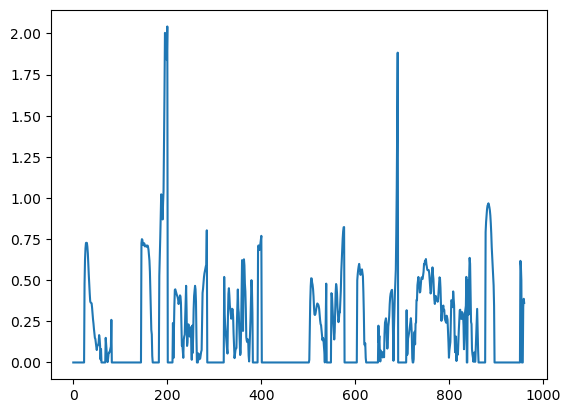

0.2098905594383137


In [ ]:
import math
actual_series_0 = actual_series[0]
pred_series_0 = pred_series_avg[0]

EPS = 1
L = len(actual_series_0)
summ = 0
diff_list = []
for i in range(L):
    if actual_series_0[i] < 1:
        # temp = abs(EPS-pred_series_0[i])/EPS
        temp = 0
    else:
        temp = abs(actual_series_0[i]-pred_series_0[i])/actual_series_0[i]    
    
    if math.isnan(temp)==True:
        temp = 0
    
    diff_list.append(temp)
    summ += temp
    

plt.plot(diff_list)
plt.show()

print(summ/L)